# Insult Classification

In this exercise, we would like to filter out insulting comments on a web forum. 

To train our models, we have a list of historic comments with a judgement wether they're insulting or not.

In [1]:
import pandas as pd
path_to_insults = '/Users/ruben/repo/personal/ga/DAT-23-NYC/data/insults/'
data = pd.read_csv(path_to_insults + 'train-utf8.csv')
data.head(2)

,Insult,Date,Comment
0,1,20120618192155Z,You fuck your dad.
1,0,20120528192215Z,i really don't understand your point. It seem...


In [2]:
print "%d comments, of which %d insults (%d%%)" % \
    (len(data), data.Insult.sum(), 100 * data.Insult.mean())

3947 comments, of which 1049 insults (26%)


### Looking for known bad words

One way to do this, is to load Google's bad word list and flag comments that contain one or more words.

- Load `google_badlist.txt` from `data/insults/`
- Add a column to `data` with a flag (0 or 1) if the comment contains a bad word
- Compute the accuracy of this method - does this look good?
- What would a naive classifier's score be (i.e., always predicting 0 or 1)?
- Also compute the precision, recall, F1 score and AUC score
- What is your verdict?

In [3]:
with open(path_to_insults + 'google_badlist.txt') as f:
    bad_words = set([line.strip() for line in f])

In [4]:
data['bad_word'] = data.Comment.map(lambda x: 1 if bad_words.intersection(x.split()) else 0)

In [5]:
data.head(2)

,Insult,Date,Comment,bad_word
0,1,20120618192155Z,You fuck your dad.,1
1,0,20120528192215Z,i really don't understand your point. It seem...,0


In [6]:
print "Flagged", data.bad_word.sum(), "comments"
print "Accuracy", (data.Insult == data.bad_word).mean()

Flagged 673 comments
Accuracy 0.708132759058


- The 70% accuracy does not look so bad, but remember that only 25% of samples is an insult. 
- If our model would never flag a comment, we would have a 75% accuracy.
- Indeed, the precision and recall look terrible.

In [7]:
print "Naive classifier (baseline): ", (data.Insult == 0).mean()
precision = (data.Insult[data.bad_word == 1] == data.bad_word[data.bad_word == 1]).mean()
recall = (data.Insult[data.Insult == 1] == data.bad_word[data.Insult == 1]).mean()
print "Precision", precision
print "Recall", recall
print "F1 score", 2 * precision * recall / (precision + recall)

Naive classifier (baseline):  0.734228527996
Precision 0.423476968796
Recall 0.271687321258
F1 score 0.331010452962


### Learning bad words on the fly

Another way of doing this, is to learn the insulting words on the fly using `CountVectorizer`. 

Please refer to the earlier notebook `text_processing.ipynb` if you forgot how to use this.

- Import `CountVectorizer` from `sklearn.feature_extraction.text`
- Train the `CountVectorizer` on the insults and create a feature set $X$ representing words in the comments
- Train `LogisticRegression` from `sklearn.linear_model` on the new feature set $X$
- Using cross-validation, compute the accuracy, precision, recall, F1 and AUC of your model
- What is your verdict?

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score

In [9]:
%%time
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(data.Comment)

CPU times: user 637 ms, sys: 30.6 ms, total: 668 ms
Wall time: 671 ms


In [10]:
%%time
# model = LogisticRegression(penalty='l1', C=100)
model = LogisticRegression()
print cross_val_score(model, X, data.Insult, cv=5).mean()

0.840638105539
CPU times: user 880 ms, sys: 13 ms, total: 893 ms
Wall time: 894 ms


In [11]:
%%time
print cross_val_score(model, X, data.Insult, cv=5, scoring='precision').mean()
print cross_val_score(model, X, data.Insult, cv=5, scoring='recall').mean()
print cross_val_score(model, X, data.Insult, cv=5, scoring='f1').mean()
print cross_val_score(model, X, data.Insult, cv=5, scoring='roc_auc').mean()

0.771543651742
0.569109136478
0.654441518631
0.874458282036
CPU times: user 3.56 s, sys: 39.9 ms, total: 3.6 s
Wall time: 3.61 s


Not bad.

Let's look at the most important features.

In [12]:
model.fit(X, data.Insult)  # fit model
coef = pd.Series(model.coef_[0], index=cv.get_feature_names())  # pair coefficients with feature names
coef.sort()  # sort from low to high

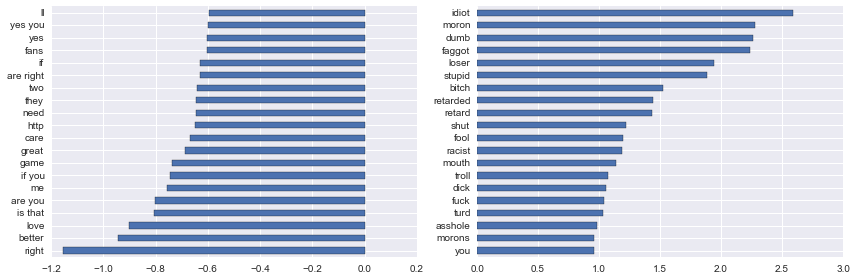

In [13]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12,4))
coef[:20].plot(kind='barh', ax=axes[0])
coef[-20:].plot(kind='barh', ax=axes[1])
f = plt.tight_layout()